In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
import shutil
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# remove outliers based on the 3 sigma rule
def remove_outliers(df, column):
    return df[np.abs(df[column] - df[column].mean()) <= (3 * df[column].std())]

# reomve outliers IQR rule
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5*IQR) & (df[column] <= Q3 + 1.5*IQR)]

In [3]:
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['path.simplify']    = True
plt.rcParams['font.family']  = 'monospace'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 3    
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handletextpad'] = 0.3
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5

In [4]:
labels = [
    "Mean Sea Level Pressure",
    "2m Temperature",
    "2m Dew Point Temperature",
    "Top Net Thermal Radiation",
    "Total Cloud Cover",
    "Total Precipitation",
    "100m Wind Speed",
    "10m Wind Speed",
    "Relative Humidity"
]
units = [
    "hPa",
    "°C",
    "°C",
    "J/m^2",
    "%",
    "mm",
    "m/s",
    "m/s",
    "%"

]
colors =[
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22"
]

months = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'
]

In [5]:
era5_df = pd.read_csv("../../data/processed/ERA5_Single_Level.csv")
era5_df['time'] = pd.to_datetime(era5_df['time'])
era5_df['tp'] = era5_df.tp * 1000
era5_df['t2m'] = era5_df.t2m - 273.15
era5_df['d2m'] = era5_df.d2m - 273.15
era5_df.head()

,time,d2m,t2m,msl,tp,v10,u10,v100,u100,ttr,tcc,wind_speed_10,wind_speed_100
0,1998-12-31 21:00:00,17.897976,19.942144,101323.855318,0.109382,0.648034,-1.475597,1.009022,-2.811511,-873001.839211,0.495752,1.611625,2.987092
1,1998-12-31 22:00:00,17.952855,20.015837,101362.271230,0.055408,-0.232797,-1.384500,-0.376840,-2.811511,-876066.526497,0.638490,1.403935,2.836653
2,1998-12-31 23:00:00,17.944585,19.709418,101384.923973,0.068102,-0.927978,-0.960242,-1.950172,-2.811511,-904910.642133,0.667170,1.335368,3.421661
3,1999-01-01 00:00:00,17.707967,18.865647,101371.079419,0.054746,-1.210370,-0.514787,-2.980013,0.348545,-854472.070282,0.655588,1.315296,3.000327
4,1999-01-01 01:00:00,17.654592,18.797554,101300.243267,0.034879,-1.281291,-0.089466,-3.089207,0.348545,-833740.362168,0.716397,1.284411,3.108807


In [6]:
era5 = era5_df.reset_index().copy()
era5['hour'] = era5['time'].dt.hour
era5['month'] = era5['time'].dt.month
era5['season'] = era5['time'].dt.month.apply(lambda x: (x%12 + 3)//3)
era5['cycle'] = era5['hour'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')
season_labels = {1: 'Summer', 2: 'Fall', 3: 'Winter', 4: 'Spring'}
era5['season'] = era5['season'].map(season_labels)
era5.head()


,index,time,d2m,t2m,msl,tp,v10,u10,v100,u100,ttr,tcc,wind_speed_10,wind_speed_100,hour,month,season,cycle
0,0,1998-12-31 21:00:00,17.897976,19.942144,101323.855318,0.109382,0.648034,-1.475597,1.009022,-2.811511,-873001.839211,0.495752,1.611625,2.987092,21,12,Summer,night
1,1,1998-12-31 22:00:00,17.952855,20.015837,101362.271230,0.055408,-0.232797,-1.384500,-0.376840,-2.811511,-876066.526497,0.638490,1.403935,2.836653,22,12,Summer,night
2,2,1998-12-31 23:00:00,17.944585,19.709418,101384.923973,0.068102,-0.927978,-0.960242,-1.950172,-2.811511,-904910.642133,0.667170,1.335368,3.421661,23,12,Summer,night
3,3,1999-01-01 00:00:00,17.707967,18.865647,101371.079419,0.054746,-1.210370,-0.514787,-2.980013,0.348545,-854472.070282,0.655588,1.315296,3.000327,0,1,Summer,night
4,4,1999-01-01 01:00:00,17.654592,18.797554,101300.243267,0.034879,-1.281291,-0.089466,-3.089207,0.348545,-833740.362168,0.716397,1.284411,3.108807,1,1,Summer,night


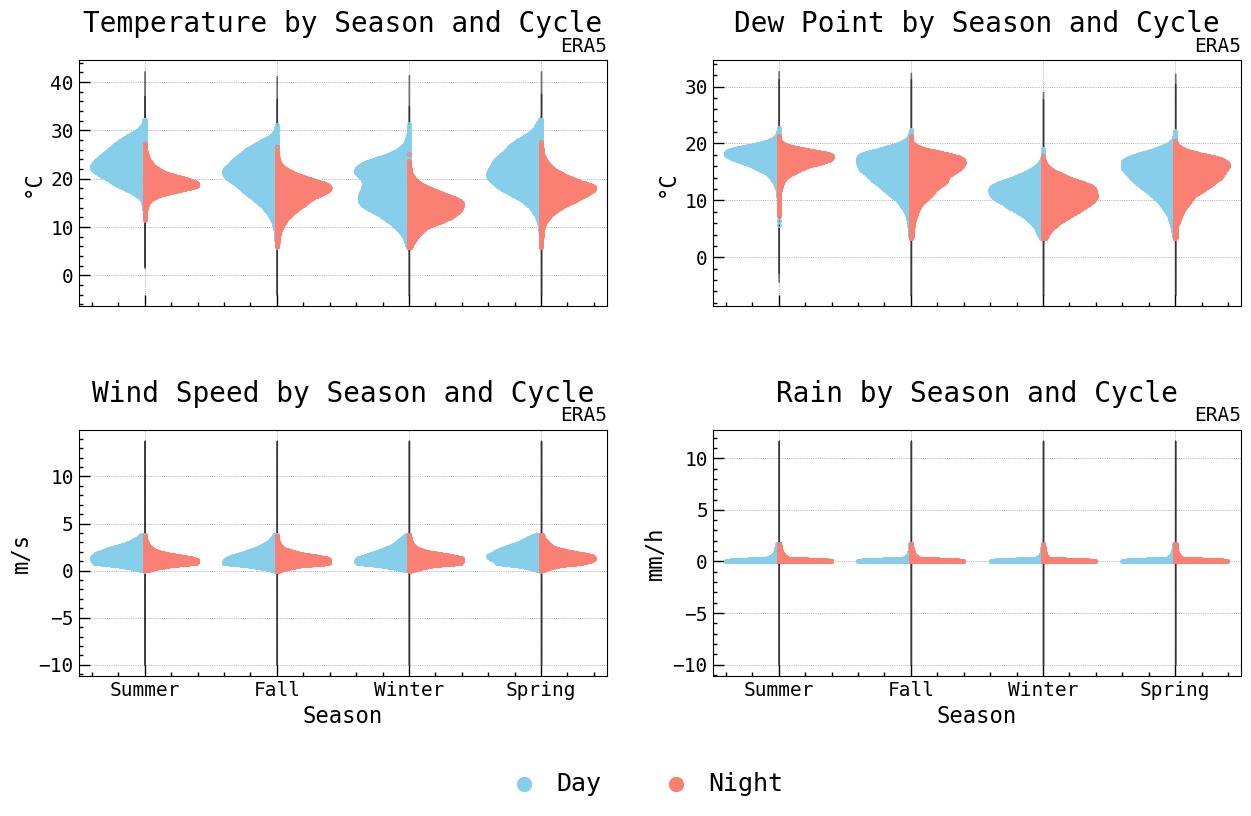

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=True)

variables = ['t2m', 'd2m', 'wind_speed_10', 'tp']
vlabels = ['Temperature', 'Dew Point', 'Wind Speed', 'Rain']
seasons = ['Summer', 'Fall', 'Winter', 'Spring']
vunits = ['°C', '°C', 'm/s', 'mm/h']
colors_cycle = ['skyblue', 'salmon']
plot_opts = {
    'bean_show_mean': False, 
    'bean_show_median': False, 
    'cutoff_val': 10, 
    'cutoff_type': 'abs', 
    'jitter_marker':'.',
    'jitter_marker_size': 5,
    # hide the legend
    'bean_legend_text': None
}

for i, variable in enumerate(variables):
    ax = axs.flat[i]
    # Preparando os dados para os ciclos diurnos e noturnos
    new_df = remove_outliers(era5, variable)
    day_data = new_df[new_df['cycle'] == 'day']
    night_data = new_df[new_df['cycle'] == 'night']

    day_values = [day_data[day_data['season'] == season][variable].dropna().values for season in ['Summer', 'Fall', 'Winter', 'Spring']]
    night_values = [night_data[night_data['season'] == season][variable].dropna().values for season in ['Summer', 'Fall', 'Winter', 'Spring']]

    # Certifique-se de que cada lista tenha múltiplos elementos
    day_values = [vals for vals in day_values if len(vals) > 1]
    night_values = [vals for vals in night_values if len(vals) > 1]

    # Plotar dados do ciclo diurno no lado esquerdo
    plot_opts['bean_color'] = 'skyblue' 
    # plot_opts['bean_legend_text'] = 'Day'
    if day_values:
        sm.graphics.beanplot(day_values, ax=ax, labels=seasons[:len(day_values)], side='left', jitter=True, plot_opts=plot_opts)

    # Plotar dados do ciclo noturno no lado direito
    plot_opts['bean_color'] = 'salmon'
    # plot_opts['bean_legend_text'] = 'Night'
    if night_values:
        sm.graphics.beanplot(night_values, ax=ax, labels=seasons[:len(night_values)], side='right', jitter=True, plot_opts=plot_opts)

    ax.set_title(f"{vlabels[i]} by Season and Cycle", y=1.08)
    ax.set_title("ERA5", loc='right', fontsize=14)
    ax.set_ylabel(vunits[i])
    if i > 1:
        ax.set_xlabel('Season')

plt.subplots_adjust(hspace=0.5)

# add legend below subplots center
ax2 = fig.add_axes([0.35, -0.05, 0.3, 0.05])
ax2.axis('off')
ax2.scatter([], [], color='skyblue', label='Day', s=100)
ax2.scatter([], [], color='salmon', label='Night', s=100)
ax2.legend(loc='center', ncol=2, fontsize=18)

plt.savefig('./results/ERA5_Season_and_Cycle.png', dpi=72, bbox_inches='tight')
plt.savefig('./results/ERA5_Season_and_Cycle.pdf', dpi=150, bbox_inches='tight')


In [8]:
# remove outliers based on the 3 sigma rule
var_outliers = ['t2m', 'd2m', 'wind_speed_10', 'tp']
for var in var_outliers:
    era5_df = remove_outliers(era5_df, var)
    

In [9]:
def p25(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 25)

def p50(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 50)

def p75(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 75)

def p90(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 90)

def p95(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 95)

def p99(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 99)


# stats_day = era5[era5['cycle'] == 'day'].groupby('season').agg({
#     't2m': ['mean', 'max', 'min', p25, p50, p75, p90, p95, p99],
#     'd2m': ['mean', 'max', 'min', p25, p50, p75, p90, p95, p99],
#     'wind_speed_10': ['mean', 'max', 'min', p25, p50, p75, p90, p95, p99],
#     'tp': ['sum', 'max', 'min', p25, p50, p75, p90, p95, p99]
# })

stats_day = pd.DataFrame()

columns = [
    't2m_mean', 't2m_max', 't2m_min', 't2m_p25', 't2m_p50', 't2m_p75', 't2m_p90', 't2m_p95', 't2m_p99',
    'd2m_mean', 'd2m_max', 'd2m_min', 'd2m_p25', 'd2m_p50', 'd2m_p75', 'd2m_p90', 'd2m_p95', 'd2m_p99',
    'wind_speed_10_mean', 'wind_speed_10_max', 'wind_speed_10_min', 'wind_speed_10_p25', 'wind_speed_10_p50', 'wind_speed_10_p75', 'wind_speed_10_p90', 'wind_speed_10_p95', 'wind_speed_10_p99',
    'rain_sum', 'rain_max', 'rain_min', 'rain_p25', 'rain_p50', 'rain_p75', 'rain_p90', 'rain_p95', 'rain_p99'
]

for variable in var_outliers:
    df_aux = era5[era5['cycle'] == 'day']
    df_aux = remove_outliers(df_aux, variable)
    
    if variable == 'tp':
        stats_day[f'{variable}_sum'] = df_aux.groupby('season')[variable].sum()
    else:
        stats_day[f'{variable}_mean'] = df_aux.groupby('season')[variable].mean()
    stats_day[f'{variable}_max'] = df_aux.groupby('season')[variable].max()
    stats_day[f'{variable}_min'] = df_aux.groupby('season')[variable].min()
    stats_day[f'{variable}_p25'] = df_aux.groupby('season')[variable].apply(p25)
    stats_day[f'{variable}_p50'] = df_aux.groupby('season')[variable].apply(p50)
    stats_day[f'{variable}_p75'] = df_aux.groupby('season')[variable].apply(p75)
    stats_day[f'{variable}_p90'] = df_aux.groupby('season')[variable].apply(p90)
    stats_day[f'{variable}_p95'] = df_aux.groupby('season')[variable].apply(p95)
    stats_day[f'{variable}_p99'] = df_aux.groupby('season')[variable].apply(p99)


stats_day.columns = columns
stats_day.T.to_csv('./results/ERA5_Seasonal_Day_Stats.csv')
stats_day

,t2m_mean,t2m_max,t2m_min,t2m_p25,t2m_p50,t2m_p75,t2m_p90,t2m_p95,t2m_p99,d2m_mean,...,wind_speed_10_p99,rain_sum,rain_max,rain_min,rain_p25,rain_p50,rain_p75,rain_p90,rain_p95,rain_p99
season,,,,,,,,,,,,,,,,,,,,,
Fall,20.928571,31.215655,7.840089,18.308492,21.164479,23.822863,25.989205,27.013545,28.435363,15.054366,...,3.609720,3836.197114,2.021302,-8.673617e-16,0.000000,0.010114,0.095054,0.376046,0.807609,1.585600
Spring,21.712961,33.736505,7.872811,18.829412,21.641333,24.677450,27.170482,28.414819,30.608431,14.377414,...,3.913617,4831.503408,2.019954,-8.673617e-16,0.000000,0.015303,0.136388,0.568271,0.988532,1.699968
Summer,23.110173,33.691145,11.903233,20.767985,22.992129,25.450757,27.541299,28.534328,30.052326,17.534760,...,3.752191,8093.269935,2.021710,-8.673617e-16,0.011379,0.090508,0.369032,0.986147,1.351413,1.842899
Winter,18.180657,31.423863,7.821627,14.933781,18.261299,21.643016,23.620372,24.631518,26.565391,10.867320,...,3.817898,1193.953092,2.012781,-8.673617e-16,0.000000,0.000000,0.005572,0.068528,0.182863,0.923770


In [10]:
def p25(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 25)

def p50(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 50)

def p75(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 75)

def p90(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 90)

def p95(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 95)

def p99(x):
    x = x[~np.isnan(x)]
    return np.percentile(x, 99)

stats_night = pd.DataFrame()

columns = [
    't2m_mean', 't2m_max', 't2m_min', 't2m_p25', 't2m_p50', 't2m_p75', 't2m_p90', 't2m_p95', 't2m_p99',
    'd2m_mean', 'd2m_max', 'd2m_min', 'd2m_p25', 'd2m_p50', 'd2m_p75', 'd2m_p90', 'd2m_p95', 'd2m_p99',
    'wind_speed_10_mean', 'wind_speed_10_max', 'wind_speed_10_min', 'wind_speed_10_p25', 'wind_speed_10_p50', 'wind_speed_10_p75', 'wind_speed_10_p90', 'wind_speed_10_p95', 'wind_speed_10_p99',
    'rain_sum', 'rain_max', 'rain_min', 'rain_p25', 'rain_p50', 'rain_p75', 'rain_p90', 'rain_p95', 'rain_p99'
]

for variable in var_outliers:
    df_aux = era5[era5['cycle'] == 'night']
    df_aux = remove_outliers(df_aux, variable)
    
    if variable == 'tp':
        stats_night[f'{variable}_sum'] = df_aux.groupby('season')[variable].sum()
    else:
        stats_night[f'{variable}_mean'] = df_aux.groupby('season')[variable].mean()
    stats_night[f'{variable}_max'] = df_aux.groupby('season')[variable].max()
    stats_night[f'{variable}_min'] = df_aux.groupby('season')[variable].min()
    stats_night[f'{variable}_p25'] = df_aux.groupby('season')[variable].apply(p25)
    stats_night[f'{variable}_p50'] = df_aux.groupby('season')[variable].apply(p50)
    stats_night[f'{variable}_p75'] = df_aux.groupby('season')[variable].apply(p75)
    stats_night[f'{variable}_p90'] = df_aux.groupby('season')[variable].apply(p90)
    stats_night[f'{variable}_p95'] = df_aux.groupby('season')[variable].apply(p95)
    stats_night[f'{variable}_p99'] = df_aux.groupby('season')[variable].apply(p99)


stats_night.columns = columns
stats_night.T.to_csv('./results/ERA5_Seasonal_Night_Stats.csv')
stats_night

,t2m_mean,t2m_max,t2m_min,t2m_p25,t2m_p50,t2m_p75,t2m_p90,t2m_p95,t2m_p99,d2m_mean,...,wind_speed_10_p99,rain_sum,rain_max,rain_min,rain_p25,rain_p50,rain_p75,rain_p90,rain_p95,rain_p99
season,,,,,,,,,,,,,,,,,,,,,
Fall,16.994246,26.637278,7.046886,15.232660,17.388552,18.976856,20.350103,21.195059,22.683305,14.574340,...,2.627435,1267.089110,1.152953,-8.673617e-16,0.00000,0.000641,0.016551,0.131999,0.328493,0.836785
Spring,17.527662,26.690519,7.050827,15.781042,17.655564,19.285282,20.995979,22.092030,24.056048,14.239724,...,2.909019,1689.259321,1.153090,-8.673617e-16,0.00000,0.002050,0.035234,0.204124,0.456255,0.936715
Summer,19.247333,26.759827,11.542492,18.058105,19.088253,20.292493,21.708781,22.669131,24.515659,17.048635,...,2.722227,2923.485521,1.153863,-8.673617e-16,0.00011,0.010954,0.123510,0.444705,0.678485,1.021981
Winter,14.039479,25.074714,7.044421,12.183656,14.115203,15.914138,17.504271,18.449834,20.131887,10.415414,...,2.728261,616.311918,1.151495,-8.673617e-16,0.00000,0.000000,0.001766,0.030841,0.101546,0.653915
